In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import cv2
import torch
import random
import numpy as np
from src.io.io import read_rgb
import matplotlib.pyplot as plt
from src.dataset import RoadDataset
from src.transform import Transform
from src.model import SegmentationModule

/Users/riccardomusmeci/Developer/github/smart-arrotino/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def visualize(image: np.array, gt_mask: np.array, mask: np.array, category: list, ):
    """plots images in one row
    """
    
    plt.figure(figsize=(32, 9))
    plt.subplot(1, 3, 1)
    plt.title(f"Grount Truth Image + Mask")
    color = np.array([0, 0, 255], dtype=np.uint8)
    if gt_mask is not None:
        masked_img = np.where(gt_mask[..., None], color, image)
        gt_image = cv2.addWeighted(image, 0.5, masked_img, 0.5, 0)
    else:
        gt_image=image
    
    # gt_image = cv2.rotate(gt_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(gt_image)
    
    plt.subplot(1, 3, 2)
    plt.title(f"Pred Mask for {category}")
    # mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # masked_img = np.where(mask[...,None], color, img)
    color = np.array([0, 0, 255], dtype=np.uint8)
    masked_img = np.where(mask[..., None], color, image)
    pred_image = cv2.addWeighted(image, 0.5, masked_img, 0.5, 0)
    # pred_image = cv2.rotate(pred_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(pred_image)
    plt.show()

In [61]:
# GDrive
# best_ckpt = {
#     "crack": "/Volumes/GoogleDrive/My Drive/GitHub/smart-arrotino/output/seg-road-crack/2022-05-10-17-08-03/checkpoint/epoch=91-step=41123-val_loss=0.617-val_iou=0.383.ckpt",
#     "pothole": "/Volumes/GoogleDrive/My Drive/GitHub/smart-arrotino/output/seg-road-pothole/2022-05-10-20-32-31/checkpoint/epoch=9-step=4469-val_loss=0.444-val_iou=0.224.ckpt"
# }

# Local
best_ckpt = {
    "crack": "/Users/riccardomusmeci/Library/CloudStorage/GoogleDrive-riccardomusmeci92@gmail.com/Il mio Drive/GitHub/smart-arrotino/output/seg-road-crack/2022-05-10-17-08-03/checkpoint/epoch=91-step=41123-val_loss=0.617-val_iou=0.383.ckpt",
    "pothole": "/Users/riccardomusmeci/Developer/github/output/smart-arrotino/pothole/2022-08-28-19-16-38/checkpoint/epoch=9-step=1690-val_loss=0.548.ckpt"
}


In [62]:
c = "pothole"
model = SegmentationModule.load_from_checkpoint(
    checkpoint_path=best_ckpt[c]
)
model.model = model.model.to("cpu")
model.model.eval();

/Users/riccardomusmeci/Developer/github/smart-arrotino/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/Users/riccardomusmeci/Developer/github/smart-arrotino/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [80]:
from sys import stderr


input_size = (512, 512)
dataset = RoadDataset(
    #data_dir="/Users/riccardomusmeci/Downloads/20220824_201523/",
    data_dir="/Users/riccardomusmeci/Developer/data/smart-arrotino/pothole/dataset/split",
    train=False,
    # data_dir="/Users/riccardomusmeci/progetti/github/dataset/road-segmentation/Dataset/test",
    transform=Transform(train=False, input_size=input_size)
)

/Users/riccardomusmeci/Developer/data/smart-arrotino/pothole/dataset/split/val/images/9337e2c9-320.jpg


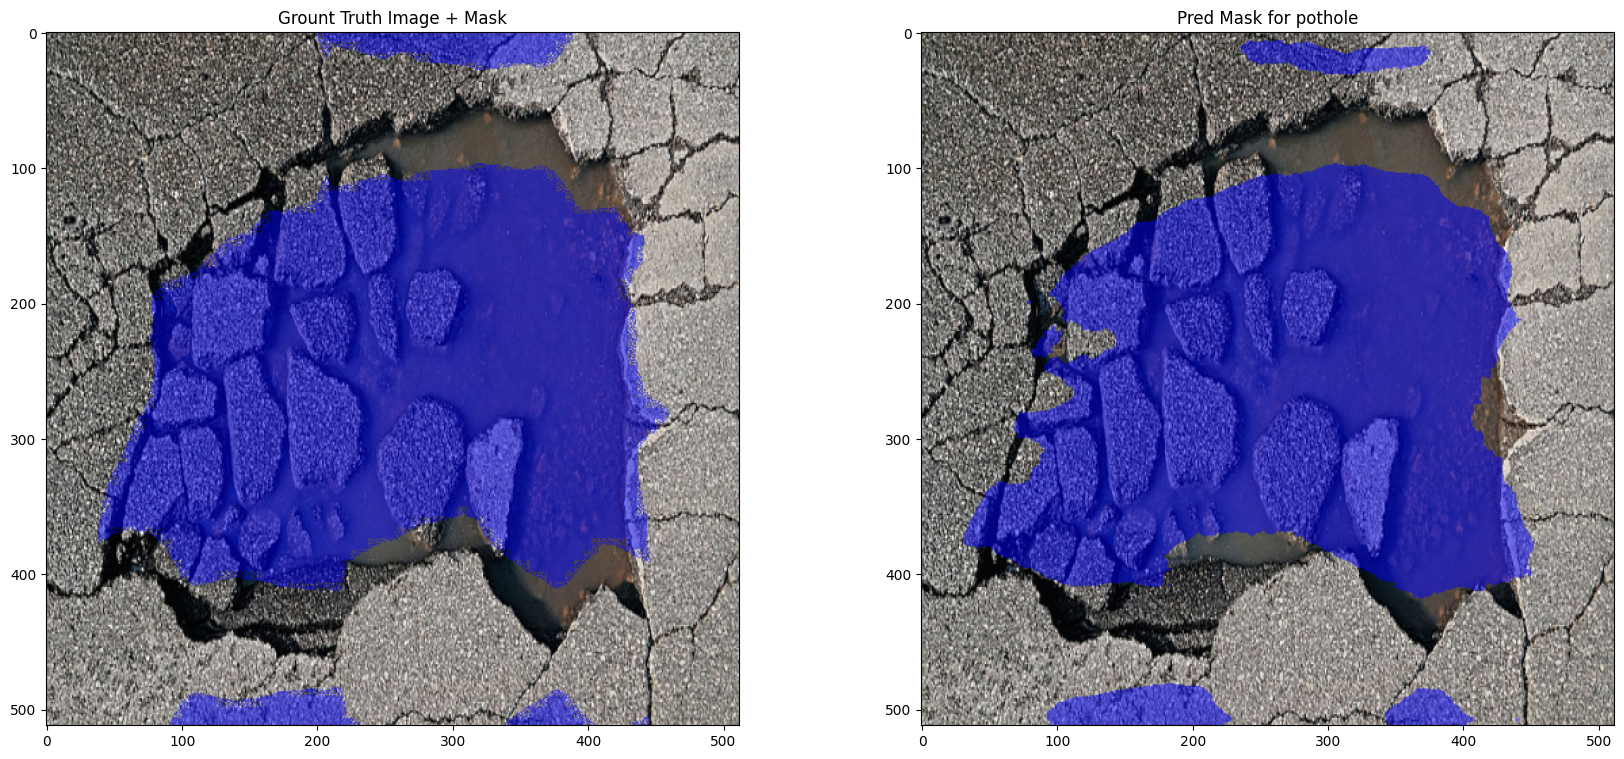

In [85]:
index = random.randint(0, len(dataset)-1)
img_path = os.path.join(dataset.images_dir, dataset.images[index])
print(img_path)
x, mask = dataset[index]

preds = model(x.unsqueeze(0))
preds = torch.sigmoid(preds)

pred_mask = preds.squeeze().squeeze().detach().numpy()
gt_mask = mask.squeeze().detach().numpy()

pred_mask[pred_mask>=0.1] = 1
pred_mask[pred_mask<0.1] = 0

image = read_rgb(file_path=img_path)
# image = x.squeeze().detach().numpy().transpose(2, 1, 0)
image = cv2.resize(image, input_size)
#image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
# gt_mask = cv2.rotate(gt_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)

visualize(
    image=image,
    gt_mask=gt_mask,
    mask=pred_mask,
    category=c
)

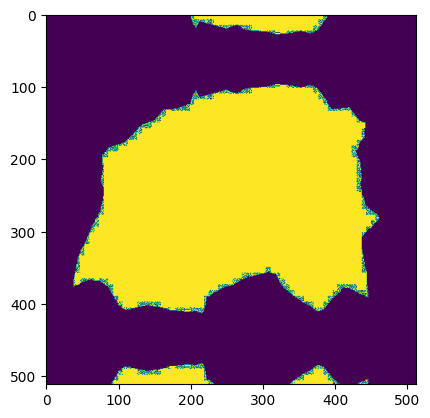

In [87]:
plt.imshow(gt_mask)